In [17]:
#import the relevant modules
import pandas as pd
import numpy as np
from pandas_datareader import data
import requests
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import dill

# Mean Reversion Trading Strategy

In [6]:
# Read in data
stocks = pd.read_excel('Russell_3000_stock_list.xlsx', skiprows=range(0,7))

# List of tickers
stocks_list = stocks['Ticker'].tolist()

# Trading logic and algorithm

In [7]:
# Create an empty list to hold our return series DataFrame for each stock
frames = []
 
# LONG Undervalued stocks:
# Signal 1: if returns from previous day's low to today's open < 1 sd of rolling 90 day close-to-close returns (gapdown: indicates short-term downward trend)
# Signal 2: open prices > rolling 20 day moving average (they have been moving down, now at the open they're moving up -> mean reversion is happening)

# SHORT Overvalued stocks: exact opposite


for stock in stocks_list:
    
    try:
 
        # Download stock data from yahoofinance and place in a DataFrame
        df = data.DataReader(stock, 'yahoo',start='1/1/2015')
        
        # Create a new column to hold our 90 day rolling stdev
        df['Stdev'] = df['Close'].rolling(window=90).std()
        
        # Create a new column to hold our 20 day moving average
        df['Moving Average'] = df['Close'].rolling(window=20).mean()
        
        # Buy: 1st signal
        df['Buy1'] = (df['Open'] - df['Low'].shift(1)) < -df['Stdev'] 
        
        # Buy: 2nd signal
        df['Buy2'] = df['Open'] > df['Moving Average']
        
        # Column to indicate if buy
        df['BUY'] = df['Buy1'] & df['Buy2']
        
        
        # Sell: 1st signal
        df['Sell1'] = (df['Open'] - df['High'].shift(1)) > df['Stdev'] 
        
        # Sell: 2nd signal
        df['Sell2'] = df['Open'] < df['Moving Average']
        
        # Column to indicate if sell
        df['SELL'] = df['Sell1'] & df['Sell2']
        
        # Calculate daily % return series for stock
        df['Pct Change'] = (df['Close'] - df['Open']) / df['Open']
        
        # Calculate the strategy's return series by using the daily stock returns mutliplied by 1 if we are long and -1 if we are short
        df['Rets'] = np.where(df['BUY'],df['Pct Change'], 0)
        df['Rets'] = np.where(df['SELL'],-df['Pct Change'], df['Rets'])
        
        # Append the strategy return series to our list
        frames.append(df['Rets'])
        
        
    except Exception as err:
        print(err)

No data fetched for symbol XTSLA using YahooDailyReader
'Date'
No data fetched for symbol WMB using YahooDailyReader
No data fetched for symbol TDG using YahooDailyReader
No data fetched for symbol FE using YahooDailyReader
No data fetched for symbol SPG using YahooDailyReader
No data fetched for symbol PPL using YahooDailyReader
No data fetched for symbol KEYS using YahooDailyReader
No data fetched for symbol FCX using YahooDailyReader
No data fetched for symbol AMP using YahooDailyReader
No data fetched for symbol AEE using YahooDailyReader
No data fetched for symbol TTD using YahooDailyReader
No data fetched for symbol AMCR using YahooDailyReader
No data fetched for symbol RSG using YahooDailyReader
No data fetched for symbol CDW using YahooDailyReader
No data fetched for symbol MRNA using YahooDailyReader
No data fetched for symbol PAYC using YahooDailyReader
No data fetched for symbol DGX using YahooDailyReader
No data fetched for symbol CBRE using YahooDailyReader
No data fetched

No data fetched for symbol SVC using YahooDailyReader
No data fetched for symbol HCAT using YahooDailyReader
No data fetched for symbol SGMS using YahooDailyReader
No data fetched for symbol INVA using YahooDailyReader
No data fetched for symbol GTY using YahooDailyReader
No data fetched for symbol FSCT using YahooDailyReader
No data fetched for symbol IGT using YahooDailyReader
No data fetched for symbol LASR using YahooDailyReader
No data fetched for symbol CYRX using YahooDailyReader
No data fetched for symbol DNOW using YahooDailyReader
No data fetched for symbol VBTX using YahooDailyReader
No data fetched for symbol CHCT using YahooDailyReader
No data fetched for symbol ALEC using YahooDailyReader
No data fetched for symbol PRSC using YahooDailyReader
No data fetched for symbol MRTN using YahooDailyReader
No data fetched for symbol MLAB using YahooDailyReader
No data fetched for symbol HCC using YahooDailyReader
No data fetched for symbol AXL using YahooDailyReader
No data fetched

No data fetched for symbol FPRX using YahooDailyReader
No data fetched for symbol UBFO using YahooDailyReader
No data fetched for symbol GLRE using YahooDailyReader
No data fetched for symbol FRGI using YahooDailyReader
No data fetched for symbol MSON using YahooDailyReader
No data fetched for symbol DHX using YahooDailyReader
No data fetched for symbol ADMA using YahooDailyReader
No data fetched for symbol RFL using YahooDailyReader
No data fetched for symbol SMBK using YahooDailyReader
No data fetched for symbol SIEN using YahooDailyReader
No data fetched for symbol OPBK using YahooDailyReader
No data fetched for symbol FGBI using YahooDailyReader
No data fetched for symbol CNCE using YahooDailyReader
No data fetched for symbol VIACA using YahooDailyReader
No data fetched for symbol SFST using YahooDailyReader
No data fetched for symbol MLP using YahooDailyReader
No data fetched for symbol RRGB using YahooDailyReader
No data fetched for symbol SHBI using YahooDailyReader
No data fetc

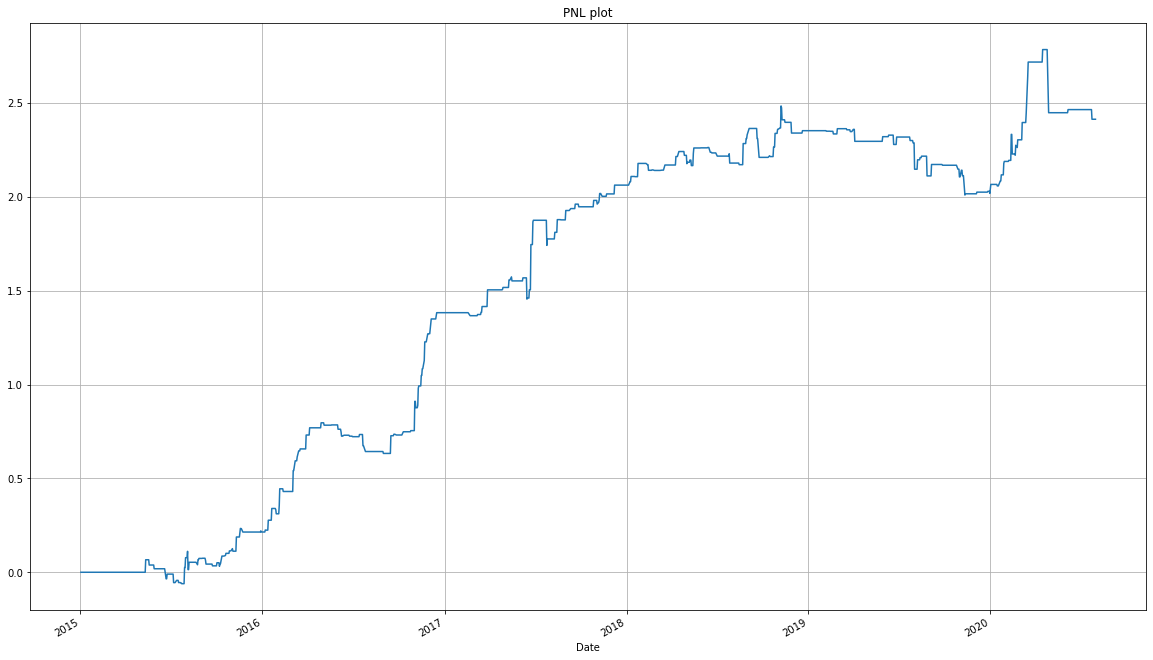

In [105]:
# Concatenate the individual DataFrames held in our list- and do it along the column axis
masterFrame = pd.concat(frames,axis=1)
 
# Create a column to hold the sum of all the individual daily strategy returns
masterFrame['Total'] = masterFrame.sum(axis=1)

# Fill 'NaNs' with zeros to allow our "count" function below to work properly
masterFrame.fillna(0,inplace=True)

# Create a column that hold the count of the number of trades that were made each day
# Minus one from it so that we dont count the "Total" column we added as a trade.
masterFrame['Count'] = (masterFrame != 0).sum(axis=1) - 1

# Create a column that divides the "total" strategy return each day by the number of stocks traded that day to get EQUALLY WEIGHTED RETURN.
masterFrame['Return'] = masterFrame['Total'] / masterFrame['Count']

# 5-year PnL plot
masterFrame['Return'].dropna().cumsum().plot(grid=True, title='PNL plot', figsize=(20,12))

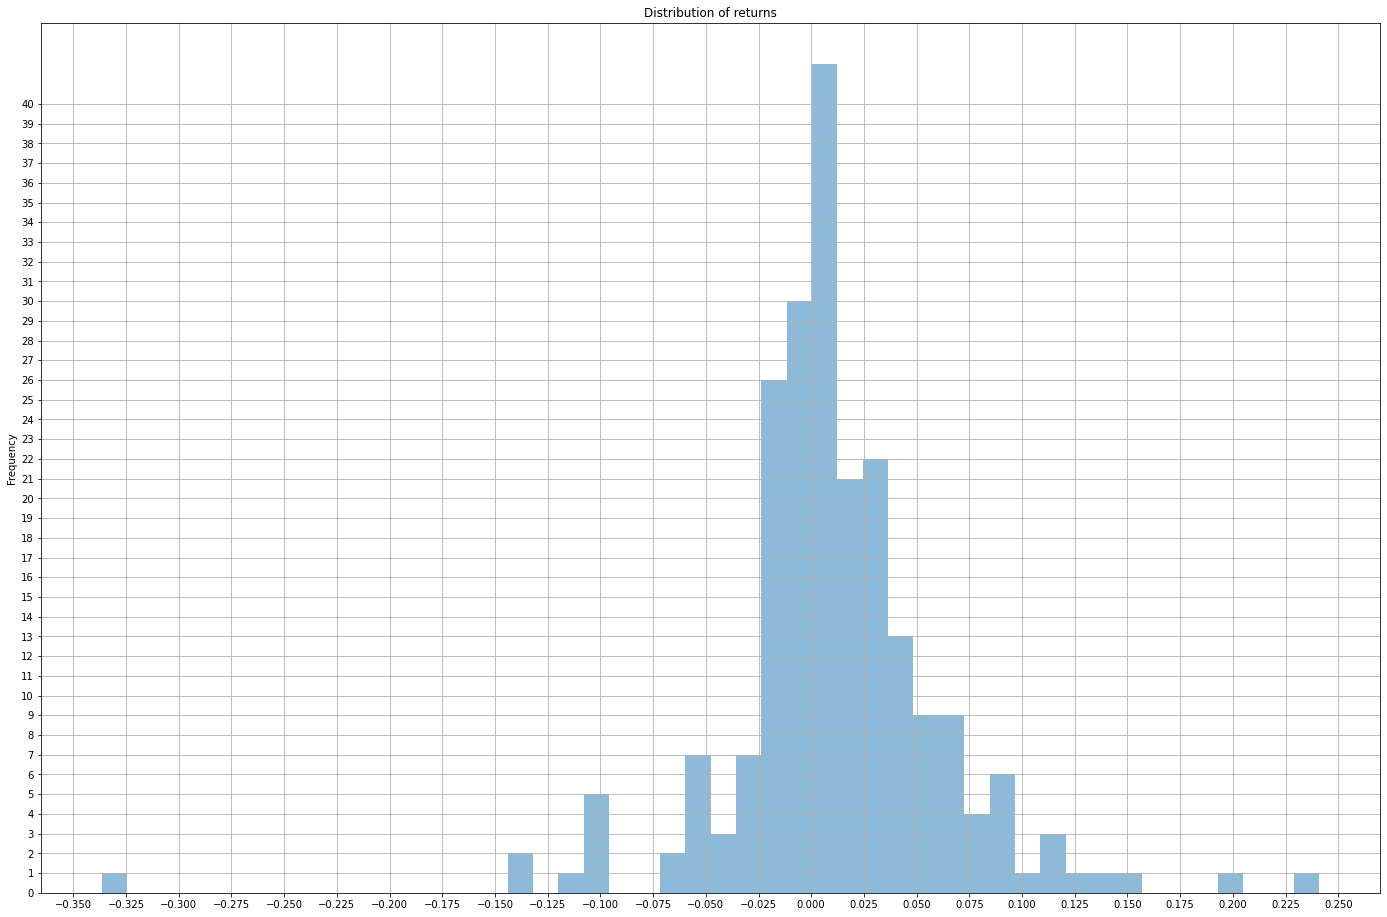

In [139]:
# Returns distribution plot
return_df = masterFrame[masterFrame['Return'] != 0]
return_df['Return'].plot.hist(bins=48, alpha=0.5, xticks=np.linspace(-0.35, 0.25, 25), yticks=np.linspace(0, 40, 41), grid=True, title='Distribution of returns', figsize=(24,16))

In [143]:
# Sharpe
sharpe = (masterFrame['Return'].mean() *252) / (masterFrame['Return'].std() * (sqrt(252)))

# Average annual return
days = (masterFrame.index[-1] - masterFrame.index[0]).days
annual = (masterFrame['Return'].dropna().cumsum()[-1]+1)**(365.0/days) - 1

print(sharpe)
print(annual)

1.266290488750064
0.2462493549287148


# Things to improve on:
1) Entirely based on price, but I have been thinking I can add some volatility measures in it (MR when less vol, i.e when noise dies out)
Right now, yahoofinance only has volume so I’ll play around with that, but if the IB API we’re gonna use have some other vol measures I’ll play with that too.
2) All positions are entered as soon as market opens and liquidated when market closes. Better if trade can be done throughout the day
3) Not accounted for transaction costs + short margin
4) Not compatible with backtesting framework

In [144]:
# Save frames and masterFrame by pickling it
%store frames
masterFrame.to_pickle('masterFrame.pkl')
dill.dump_session('main_v2.db')

Stored 'frames' (list)


In [4]:
import dill
dill.load_session('main_v2.db')

C:\Users\16103\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Backtesting framework compatibility

In [33]:
import Algo, Backtest

In [35]:
for stock in stocks_list[:3]:
    algo = Algo.MinhsAlgo(stock)
    back = Backtest.Backtest(algo, 10000, 5)
    back.run_backtest()
    back.generate_report()


[*********************100%***********************]  1 of 1 completed


TypeError: run_algo() takes 1 positional argument but 2 were given